# Import relevant packages: numpy, matplotlib, iris, windsparm, aeolus, cartopy

In [21]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs  
from matplotlib import ticker, cm

import aeolus

from aeolus.calc.stats import cumsum, spatial
from aeolus.const import init_const
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels

pcb_const=init_const('proxb')




In [2]:
warnings.filterwarnings("ignore")


# Load the data: ask for availability of dataset and change to local directories

In [30]:
pcb_32 = iris.load('../data/pcb_32_fix_17120_120.nc')
pcb_32_ageair = iris.load('../data/pcb_32_fix_ageair_tevol.nc')

In [31]:
# Functions to rename height coordinate, take hemispheric averages

In [32]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_32)
newheight(pcb_32_ageair)


In [22]:
def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def height_to_pressure(cube, pressurecube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 

# Function plot_tsurf uses the 3D CCM datacube to extract surface temperature (in K) and winds (m/s), for time-averaged (<i>time_mean=True</i>) or specific timestep (<i>time_slice=..</i>). Vertical levels of winds can be chagned (<i>vert_slice=..</i>), and sublabels and save options can be changed to preference. See Figure 2 in the paper.

Hemis diff: [4.10223388671875]
Mean temp: [261.9638366699219]
Minimum temp: [196.36044]
Max temp: [292.3828]
The mean hotspot temperatures are: 279.6982421875
Pressure for winds (hPa): 236.34609375
Altitude for winds (m): [8819.999]


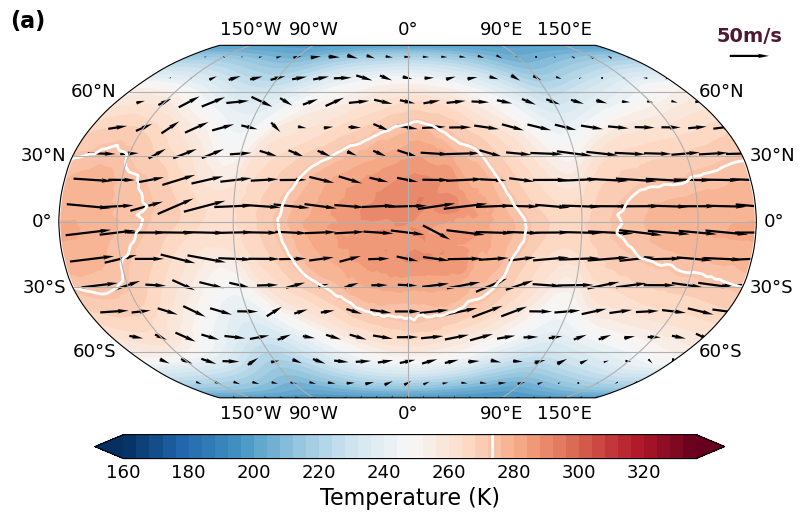

Hemis diff: [-4.150146484375]
Mean temp: [261.9142761230469]
Minimum temp: [196.48875]
Max temp: [291.1103]
The mean hotspot temperatures are: 279.5577799479167
Pressure for winds (hPa): 235.24681640625
Altitude for winds (m): [8819.999]


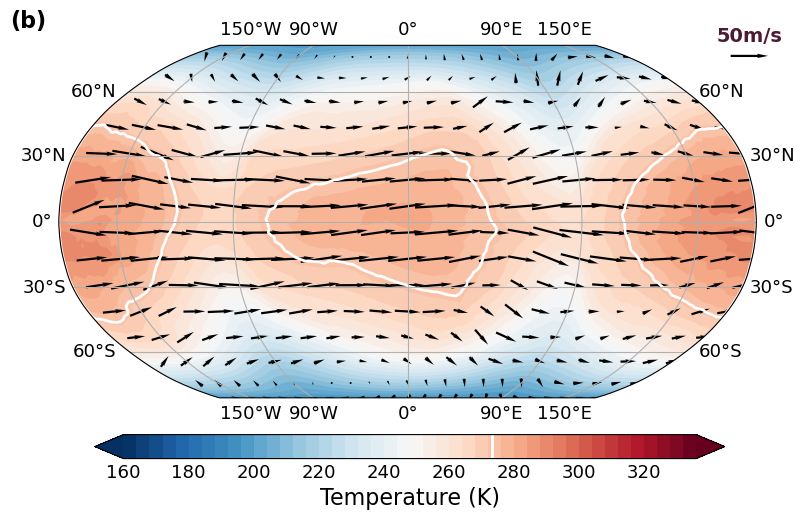

Hemis diff: [-0.16314697265625]
Mean temp: [260.96502685546875]
Minimum temp: [197.83177]
Max temp: [282.15143]
The mean hotspot temperatures are: 277.6128402722178
Pressure for winds (hPa): 237.211484375
Altitude for winds (m): [8819.999]


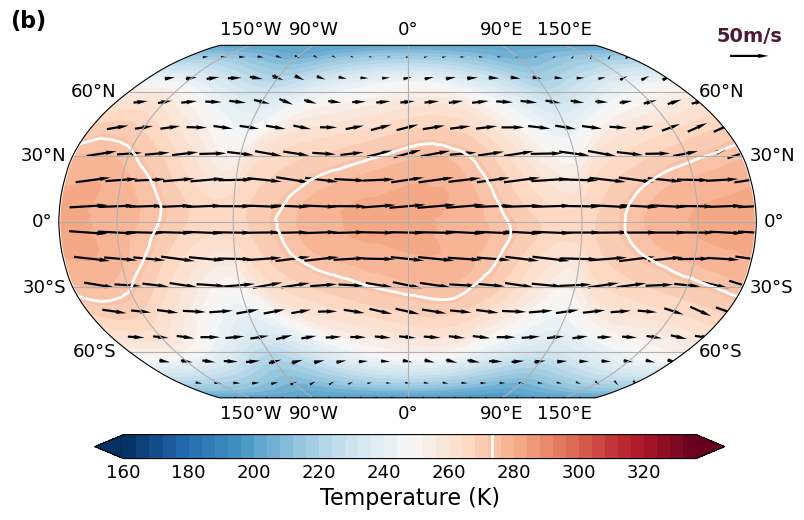

In [9]:


def plot_tsurf(cubes, time_slice=-1, vert_slice=-1, time_mean=False, markers=False, sublabel=False,
               sublabel_t='a',save=False, name=None):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                x_wind = cube[:100,:,:,:].copy()
                x_wind=x_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            y_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                y_wind = cube[:100,:,:,:].copy()
                y_wind=y_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='surface_temperature':
            temperature = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                temperature = cube[:100,:,:,:].copy()
                temperature=temperature.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_pressure':
            pressure = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                pressure = cube[:100,:,:,:].copy()
                pressure=pressure.collapsed('t', iris.analysis.MEAN)
    
    y_wind = y_wind.regrid(x_wind, iris.analysis.Linear())
    xlon = x_wind.coord('longitude')
    ylon = y_wind.coord('longitude')
    #Calculate and print some statistics
    daymean, nightmean= hemisphere_sep(temperature)
    print('Hemis diff:', daymean.data-nightmean.data)
    print('Mean temp:', zonal_mean(meridional_mean(temperature)).data)
    print('Minimum temp:', spatial(temperature, 'min').data)
    print('Max temp:', spatial(temperature, 'max').data)
    # Calculate the mean value over all the grid points that adhere to the threshold
    above_threshold = temperature[0,:,:].copy(data=np.ma.masked_where(temperature[0,:,:].data 
                                                                      <= 273.15, temperature[0,:,:].data))
    tmean_hotspots = above_threshold.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    print('The mean hotspot temperatures are:', tmean_hotspots.data)
    # Create a cube containing the wind speed
    windspeed = (y_wind** 2 + x_wind ** 2) ** 0.5
    windspeed.rename('windspeed')
    xe = xlon.points
    ye = y_wind.coord('latitude').points
    ue = x_wind[vert_slice, :, :].data
    ve = y_wind[vert_slice, :, :].data
    print('Pressure for winds (hPa):', pressure[vert_slice,0,0].data/100)
    print('Altitude for winds (m):', pressure[vert_slice,0,0].coord('level_height').points)
    
    #Define levels for freezing point and all regions
    levs273=np.arange(273.14,273.16,1)
    levs_c = np.arange(160,340,4)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    if sublabel==True:
        ax.text(-0.07,1.05, sublabel_t, size=16, weight='bold',transform=ax.transAxes)
    c=iplt.contourf(temperature[0,:,:], linewidth=0, levels=levs_c, extend='both', cmap='RdBu_r')#Temp distribution
    c2 = iplt.contour(temperature[0,:,:], levs273,linewidths=2.0, colors='white', linestyles='-')#273.15 K line
    #Add wind arrows
    qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2, transform=ccrs.PlateCarree())
    ax.quiverkey(qv1, 0.99, 0.97, 50, r'50m/s', labelcolor=(0.3, 0.1, .2, 1), fontproperties={'size': 14, 'weight': 'bold'})
                  # labelpos='N', coordinates = 'figure', )    
    cbaxes = plt.axes([0.165, 0.1, 0.7, 0.04]) 
    cbar = fig.colorbar(c, orientation='horizontal',cax = cbaxes)
    cbar.ax.set_xlabel('Temperature (K)', fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=13) 
    cbar.ax.axvline(273.15, c='w', lw=2)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = ticker.FixedLocator([-150, -90, 0, 90, 150])
    gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    gl.rotate_labels = False    
    if save==True:
        plt.savefig('%s.pdf' %(name), bbox_inches = 'tight')
    plt.show()


plot_tsurf(pcb_32, time_slice=7, vert_slice=21, time_mean=False, markers=False, save=False, name='pcb_32_tsurf_7', 
           sublabel=True, sublabel_t='(a)')
plot_tsurf(pcb_32, time_slice=18, vert_slice=21, time_mean=False, markers=False, save=False, name='pcb_32_tsurf_18', 
           sublabel=True, sublabel_t='(b)')#6000.5
plot_tsurf(pcb_32, time_slice=10, vert_slice=21, time_mean=True, markers=False, save=False, name='pcb_32_tsurf_11', 
           sublabel=True, sublabel_t='(b)')#6000.5

# Function plot_toc uses the 3D CCM datacube to extract ozone column density, in DU (1 DU = 2.687*10$^{20}$ molecules m$^{-2}$) for time-averaged (<i>time_mean=True</i>) or specific timestep (<i>time_slice=..</i>). Vertical levels of winds can be chagned (<i>vert_slice=..</i>), and sublabels and save options can be changed to preference. Shown in paper Figure 4.

Average ozone column density (DU): 731.0620037433166
Minimum ozone column density (DU): 610.82153
Maximum  ozone column density (DU): 863.6489
Hemispheric difference (DU): -51.256348


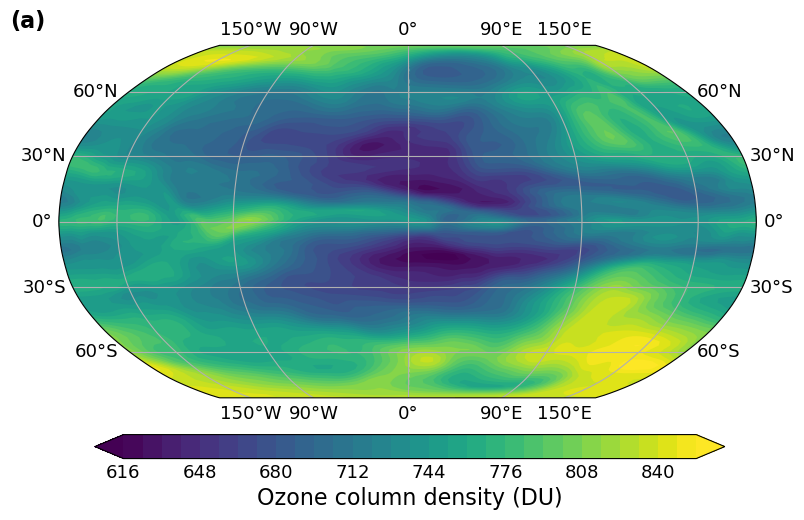

Average ozone column density (DU): 731.0070152880513
Minimum ozone column density (DU): 612.93286
Maximum  ozone column density (DU): 878.2646
Hemispheric difference (DU): 49.655518


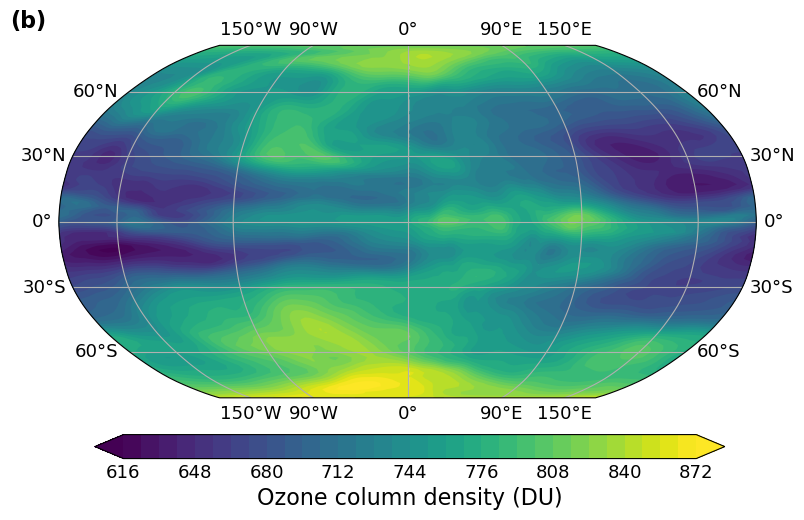

In [16]:
def plot_toc(cubes, time_slice=-1, time_mean=False, save=False,sublabel=False,
               sublabel_t='(a)'):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                x_wind = cube[:,:,:,:].copy()
                x_wind=x_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            y_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                y_wind = cube[:,:,:,:].copy()
                y_wind=y_wind.collapsed('t', iris.analysis.MEAN)            
        if cube.long_name =='Stash code = 50219':
            o3coldens = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                o3coldens = cube[:,:,:,:].copy()
                o3coldens=o3coldens.collapsed('t', iris.analysis.MEAN)    

    print('Average ozone column density (DU):', spatial(o3coldens[0], 'mean').data)
    print('Minimum ozone column density (DU):', spatial(o3coldens[0], 'min').data)
    print('Maximum  ozone column density (DU):', spatial(o3coldens[0], 'max').data)   
    daymean, nightmean= hemisphere_sep(o3coldens[0])
    print('Hemispheric difference (DU):', daymean.data-nightmean.data)
    lev_expcol = np.arange(2.4,3.2,0.01)
    levscol = np.power(10, lev_expcol)
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    
    if sublabel==True:
        ax.text(-0.07,1.05, sublabel_t, size=16, weight='bold',transform=ax.transAxes)
    c=iplt.contourf(o3coldens[0,:,:], linewidth=0, levels=40, extend='both', cmap='viridis')#, locator=ticker.LogLocator())
    cbaxes = plt.axes([0.165, 0.1, 0.7, 0.04]) 
    cbar = fig.colorbar(c, orientation='horizontal',cax = cbaxes)
    cbar.ax.set_xlabel('Ozone column density (DU)', fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=13) 
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = ticker.FixedLocator([-150, -90, 0, 90, 150])
    gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    gl.rotate_labels = False

    if save==True:
        plt.savefig('pcb_toc_32res_%s.pdf' %(time_slice), bbox_inches = 'tight')
    plt.show()
plot_toc(pcb_32, time_slice=7, time_mean=False, save=True, sublabel=True,sublabel_t='(a)')
plot_toc(pcb_32, time_slice=18, time_mean=False, save=True, sublabel=True,sublabel_t='(b)')

# Function ageofair_moldistrib plots the age of air tracer in the final timesteps as contourlines over a background contour of ozone (either VMR or number density). Different regions of the planet can be chosen, here we use the zonal mean meridional distributions, as shown in Figure 9.

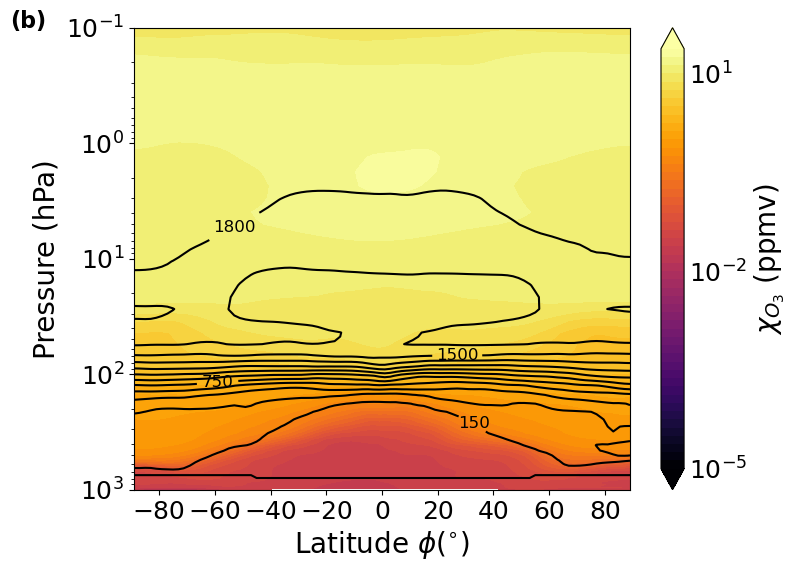

In [38]:
def ageofair_moldistrib(cubelist1, cubelist2, lname_mol='O3 MASS MIXING RATIO', m_mol=48, time_slice_l=0,
                                              time_slice_u=120,vmin=None, vmax=None, vmr_plot=False, save=False, sublabel=False, sublabel_t='a',
                                   tl_coords=False, day_cube=False, night_cube=False, max_o3=2e3, const=None, model=aeolus.model.um,
                                             lat_min=-90, lat_max=90, lon_min=90,lon_max=270):
    for cube in cubelist1:
        if cube.standard_name =='air_pressure':
            pres_cube_slices = iris.cube.CubeList([cube[slice_start:slice_end,:,:,:].copy() for slice_start, slice_end in time_slices])
            pres_cube=pres_cube_slices.concatenate()[0]  
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                pres_cube=pres_cube.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                pres_cube=pres_cube.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.standard_name =='air_temperature':
            temp_cube_slices = iris.cube.CubeList([cube[slice_start:slice_end,:,:,:].copy() for slice_start, slice_end in time_slices])
            temp_cube=temp_cube_slices.concatenate()[0]  
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                temp_cube=temp_cube.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                temp_cube=temp_cube.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.long_name =='AGE OF AIR IN SECONDS':
            ageair_slices = iris.cube.CubeList([cube[slice_start:slice_end,:,:,:].copy() for slice_start, slice_end in time_slices])
            ageair=ageair_slices.concatenate()[0]  
            ageair=ageair.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                ageair=ageair.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                ageair=ageair.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.long_name == lname_mol:
            vmr_slices = iris.cube.CubeList([cube[slice_start:slice_end,:,:,:].copy() for slice_start, slice_end in time_slices])
            vmr=vmr_slices.concatenate()[0]  
            vmr=vmr.collapsed('t', iris.analysis.MEAN)*29.3/m_mol
            if day_cube==True:
                vmr=vmr.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                vmr=vmr.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
    for cube in cubelist2:
        if cube.long_name =='AGE OF AIR IN SECONDS':
            ageair = cube[-1,:,:,:].copy()
            if day_cube==True:
                ageair=ageair.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                ageair=ageair.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
    height = [('level_height', ageair.coord('level_height').points)]
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    vmr = vmr.interpolate(height, iris.analysis.Linear())
    if vmr_plot==False:
        vmr = vmr_molec(vmr, pres_cube, temp_cube)
    vmr_p = height_to_pressure(vmr, pres_cube)
    ageair_p = height_to_pressure(ageair, pres_cube)
    vmr_zonal_p = zonal_mean(vmr_p)
    vmr_meridional_p = meridional_mean(vmr_p)
    vmr_zonal = zonal_mean(vmr)
    vmr_meridional = meridional_mean(vmr)
    ageair_zonal_p = zonal_mean(ageair_p)
    ageair_meridional_p = meridional_mean(ageair_p)    
  
    if vmr_plot==False:
        lev_exp_vmr2 = np.arange(15,20,0.2)
        levs_vmr2 = np.power(10, lev_exp_vmr2)
        lev_exp_vmr = np.arange(16,20,0.125)
        levs_vmr = np.power(10, lev_exp_vmr)
    else:
        lev_exp_vmr2 = np.arange(-5,1.5,0.2)
        levs_vmr2 = np.power(10, lev_exp_vmr2)
        lev_exp_vmr = np.arange(-5,1.5,0.125)
        levs_vmr = np.power(10, lev_exp_vmr)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.25,1.0, sublabel_t, size=16, weight='bold',transform=ax.transAxes)


    cs2 = plt.contour(ageair_zonal_p.coord('latitude').points, ageair_zonal_p.coord('air_pressure').points/100,
                     ageair_zonal_p.data/(3600*24), levels=15, colors='black')
#     cs2 = plt.contour(ageair_meridional_p.coord('longitude').points, ageair_meridional_p.coord('air_pressure').points/100,
#                       ageair_meridional_p.data, levels=15, colors='black')
    labels1=plt.clabel(cs2, cs2.levels[[1,5,10,12]], fmt='%1.0f', inline=True, fontsize=12, inline_spacing=10)
    for l in labels1:
        l.set_rotation(0)
    cs = plt.contourf(vmr_zonal_p[:,:].coord('latitude').points, vmr_zonal_p[:,:].coord('air_pressure').points/100, 
                     vmr_zonal_p[:,:].data*1e6, levels=levs_vmr2, extend='both', 
                      cmap='inferno', locator=ticker.LogLocator())
    cs = plt.contourf(vmr_zonal_p[:,:].coord('latitude').points, vmr_zonal_p[:,:].coord('air_pressure').points/100, 
                     vmr_zonal_p[:,:].data*1e6, levels=levs_vmr, extend='both', 
                     cmap='inferno', locator=ticker.LogLocator())
#     cs = plt.contourf(vmr_meridional_p[:,:].coord('longitude').points, vmr_meridional_p[:,:].coord('air_pressure').points/100, 
#                      vmr_meridional_p[:,:].data*1e6, levels=levs_vmr2, extend='both', 
#                       cmap='inferno', locator=ticker.LogLocator())
#     cs = plt.contourf(vmr_meridional_p[:,:].coord('longitude').points, vmr_meridional_p[:,:].coord('air_pressure').points/100, 
#                      vmr_meridional_p[:,:].data*1e6, levels=levs_vmr, extend='both', 
#                      cmap='inferno', locator=ticker.LogLocator())
    cbar = fig.colorbar(cs)
    if vmr_plot==False:
        cbar.ax.set_ylabel('Number density (molec cm$^{-3}$)', rotation=90, fontsize=16)
    else:
        cbar.ax.set_ylabel('$\chi_{O_3}$ (ppmv)', rotation=90, fontsize=20)

    cbar.ax.tick_params(length=0, labelsize=18)
    plt.xlabel('Latitude $\phi (^{\circ})$', fontsize=20)

    plt.ylabel('Pressure (hPa)', fontsize=20)
    plt.yscale('log')
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-1)#96500
    if vmr_plot==False:
        if save==True:
            plt.savefig('pcb_32_no3_ageair_merid.pdf', bbox_inches = 'tight')
    else:
        if save==True:
            plt.savefig('pcb_32_vmro3_merid.png', bbox_inches = 'tight')
    plt.show()


ageofair_moldistrib(pcb_32, pcb_32_ageair, const=pcb_const, vmr_plot=True, save=False, night_cube=False, 
                    sublabel=True, sublabel_t='(b)')